In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from metpy.units import units

import datetime as dt
from sklearn.metrics import r2_score
from metpy.units import units
import math 
import geopandas as gpd

In [2]:
HEIGHTS = [1,3,10]
data_start_date = '20221107'
data_cutoff_date = '20230619'
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

# Open data

SOS

In [3]:
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
sos_df = sos_df[sos_df.time > data_start_date][sos_df.time < data_cutoff_date]
sos_df = sos_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82686/2649536835.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sos_df = sos_df[sos_df.time > data_start_date][sos_df.time < data_cutoff_date]


SAIL

Get hygrothermometer measurements

In [4]:
kps_file_list = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledseb.asfs30.level2.0.10min.' in f
])[385:]
kps_file_list[0], kps_file_list[-1]

('/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb.asfs30.level2.0.10min.20221101.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb.asfs30.level2.0.10min.20230719.000000.nc')

In [5]:
avp_file_list = sorted([
    os.path.join(avp_download_dir, f) for f in os.listdir(avp_download_dir) 
    if 'sledseb.asfs50.level2.0.10min.' in f
])[385:]
avp_file_list[0], avp_file_list[-1]

('/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221101.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230621.000000.nc')

In [6]:
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='10GB')

In [256]:
kpsann_ds_lazy = xr.open_mfdataset(
    kps_file_list, combine='nested', concat_dim='time', compat='override', coords='all', parallel=True
)
kpsann_df = kpsann_ds_lazy[['time', 'temp', 'atmos_pressure', 'down_long_hemisp', 'skin_temp_surface']].to_dask_dataframe().compute()
kpsann_df_30min = kpsann_df.set_index('time').resample('30min').mean()

In [258]:
avp_ds_lazy = xr.open_mfdataset(
    avp_file_list, combine='nested', concat_dim='time', compat='override', coords='all', parallel=True
)

In [ ]:
avp_df = avp_ds_lazy[['time', 'temp', 'atmos_pressure', 'down_long_hemisp', 'skin_temp_surface']].to_dask_dataframe().compute()

In [ ]:
avp_df_30min = avp_df.set_index('time').resample('30min').mean()

Get sonic temperature measurements - from the fast data

In [9]:
fast_files_avp = sorted([
    os.path.join(avp_download_dir, f) for f in os.listdir(avp_download_dir) 
    if 'sledwind10hz.asfs50.level2.0.' in f
])[385:]
fast_files_avp


['/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221101.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221102.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221103.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221104.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221105.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221106.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.20221107.000000.nc',
 '/Users/elischwat/D

In [10]:
list_of_Ts_measurements = []
for file in tqdm.tqdm(fast_files_avp):
    list_of_Ts_measurements.append(
        xr.open_dataset(os.path.join(avp_download_dir, file))[['metek_T']].to_dask_dataframe().set_index('time').compute().resample('30min').mean()
    )
Ts_meas_avp = pd.concat(list_of_Ts_measurements).sort_index()

100%|██████████| 180/180 [00:40<00:00,  4.49it/s]


In [11]:
fast_files_kps = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledwind10hz.asfs30.level2.0.' in f
])[385:]
fast_files_kps

['/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221101.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221102.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221103.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221104.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221105.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221106.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledwind10hz.asfs30.level2.0.20221107.000000.nc',
 '/Users/elischwat/D

In [12]:
list_of_Ts_measurements = []
for file in tqdm.tqdm(fast_files_kps):
    list_of_Ts_measurements.append(
        xr.open_dataset(os.path.join(kps_download_dir, file))[['metek_T']].to_dask_dataframe().set_index('time').compute().resample('30min').mean()
    )
Ts_meas_kps = pd.concat(list_of_Ts_measurements).sort_index()

100%|██████████| 261/261 [00:59<00:00,  4.40it/s]


# Create categories

In [13]:
# Identify lists of timestamps for different categories
bs_times = set(
    sos_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(sos_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(sos_df.time).difference(bs_times)

decoupled_times = sos_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = sos_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = sos_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = sos_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = sos_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = sos_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = sos_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = sos_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = sos_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = sos_df[sos_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = sos_df[sos_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

len(upvalley_wind_times),len(downvalley_wind_times)

(1825, 5643)

# Do Advection Calculations

## Collect temperature data, in a vertical profile on tower c

In [14]:
## Isolate humidity measurements (from hygrometers)
temp_profile_df = sos_df[sos_df.measurement == 'temperature'].pivot_table(
    index='time', columns=['height', 'tower', 'measurement'], values='value'
)

# Combine with snow depth data
temp_profile_df = temp_profile_df.melt(ignore_index=False).join(
    sos_df[sos_df.variable == 'SnowDepth_c'].set_index('time')['value'].rename('snow depth')
)

# Calculate instrument height above snow surface
temp_profile_df['instrument_height'] = temp_profile_df['height'] - temp_profile_df['snow depth']

# Filter out measurements that are buried in the snow
temp_profile_df = temp_profile_df[
    (temp_profile_df['instrument_height'] > 0)
    | (temp_profile_df['height'] == 0)
]

temp_profile_df['instrument_height'] = temp_profile_df['instrument_height'].where(
    temp_profile_df['instrument_height'] > 0,
    0
)

temp_profile_df

,height,tower,measurement,value,snow depth,instrument_height
time,,,,,,
2022-11-07 00:30:00,1.0,c,temperature,-2.611392,0.029834,0.970166
2022-11-07 01:00:00,1.0,c,temperature,-2.597149,0.030787,0.969213
2022-11-07 01:30:00,1.0,c,temperature,-2.584403,0.031069,0.968931
2022-11-07 02:00:00,1.0,c,temperature,-2.132004,0.031351,0.968649
2022-11-07 02:30:00,1.0,c,temperature,-2.389273,0.025319,0.974681
...,...,...,...,...,...,...
2023-06-18 21:30:00,20.0,c,temperature,12.956008,0.005173,19.994827
2023-06-18 22:00:00,20.0,c,temperature,11.053670,0.006668,19.993332
2023-06-18 22:30:00,20.0,c,temperature,11.217368,0.005557,19.994443


In [15]:
from sublimpy.gradients import LogPolynomialWithRoughness

def calculate_temp_gradient(
        one_ts_groupby,
        height4estimate,
        Z0Q = 0.005
    ):
    """ 
    Calculates mixing ratio gradient from a dataframe with datetimeindex,
    and columns `instrument_height`  and `value`, which holds mixing ratio
    values. These calculations are done by fitting log-polynomial curve to 
    measurements of z and X where X is some measured variable.
    We include a boundary wall condition, applying measured X at
    roughness height (T=T_s at z=z0). We also adjust for snow depth 
    in our calculations.
    """    
    heights = one_ts_groupby.sort_values('instrument_height')['instrument_height']
    values = one_ts_groupby.sort_values('instrument_height')['value']

    heights = heights.replace(0,Z0Q)

    # calculate fitted loglinear parameters
    params = LogPolynomialWithRoughness.fit_function(
        values,
        heights
    )
    values_pred = [
        LogPolynomialWithRoughness.function(z, params[0], params[1], params[2])
        for z in heights
    ]
    a = params[0]
    b = params[1]
    gradient = LogPolynomialWithRoughness.gradient_single_component(height4estimate, a, b)
    return gradient, a, b, heights, values, values_pred

Text(0, 0.5, 'height above snow(m)')

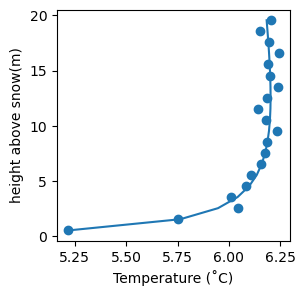

In [16]:
gradient, a, b, heights, values, values_pred =  calculate_temp_gradient(
    temp_profile_df.groupby('time').get_group('2023-05-05 12:30:00'),
    3   
)
c = values[0]
plt.figure(figsize=(3,3))
plt.plot(values_pred, heights)
plt.scatter(values, heights)

plt.xlabel('Temperature (˚C)')
plt.ylabel('height above snow(m)')

## Calculate $dT/dz$ and Vertical Advection for all timestamps

We calculate at the heights of the EC instruments.

In [17]:
def get_dT_dz_values_for_height(H):
    dT_dz = temp_profile_df.reset_index().swifter.groupby('time').apply(
        lambda df: calculate_temp_gradient(df, H)[
            :3 # drop the extra outputs
        ]
    )
    dT_dz = pd.DataFrame(dT_dz.tolist()).rename(columns={
        0: 'dT_dz',
        1: 'fit_param_a',
        2: 'fit_param_b',
        # 3: 'heights',
        # 4: 'values', 
        # 5: 'values_pred'
    }).assign(time = dT_dz.index).set_index('time')

    return dT_dz.drop_duplicates()

def add_variables_to_dT_dz_values(H, dT_dz_values, tidy_df_specific_pf):
    return dT_dz_values.join(
        tidy_df_specific_pf.query(f"variable == 'w_{H}m_c'").set_index('time')['value'].rename(f"w_{H}m_c")
    ).join(
        tidy_df_specific_pf.query(f"variable == 'w_tc__{H}m_c'").set_index('time')['value'].rename(f"w_tc__{H}m_c")
    )

def get_advection_df(H, tidy_df_specific_pf):
    df = get_dT_dz_values_for_height(H)
    df = add_variables_to_dT_dz_values(H, df, tidy_df_specific_pf) 
    df[f"vertical_advection_{H}m_c"] = df[f"w_{H}m_c"]*df["dT_dz"]
    return df.drop(columns = ['dT_dz', 'fit_param_a', 'fit_param_b'])

In [18]:
### 3 sector
dT_dz_values_for_height = {
    2:      get_advection_df(2,     sos_df),
    3:      get_advection_df(3,     sos_df),
    5:      get_advection_df(5,     sos_df),
    10:     get_advection_df(10,    sos_df),
    15:     get_advection_df(15,    sos_df),
    20:     get_advection_df(20,    sos_df),
}

  0%|          | 0/22 [00:00<?, ?it/s]

2025-09-08 22:37:44,276	INFO worker.py:1781 -- Started a local Ray instance.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [19]:
from functools import reduce
adv_df = reduce(lambda  left,right: 
                   left.join(right), list(dT_dz_values_for_height.values())
)

## Calculate Flux Divergence

In [20]:
flux_divergence_df = sos_df[sos_df.variable.isin([
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__20m_c',
])].pivot(index='time', columns='variable', values='value')
flux_divergence_df['vertical_turb_flux_divergence_3to5'] = (
    flux_divergence_df['w_tc__5m_c'] - flux_divergence_df['w_tc__3m_c']
) / 2
flux_divergence_df['vertical_turb_flux_divergence_3to10'] = (
    flux_divergence_df['w_tc__10m_c'] - flux_divergence_df['w_tc__3m_c']
) / 7
flux_divergence_df['vertical_turb_flux_divergence_3to20'] = (
    flux_divergence_df['w_tc__20m_c'] - flux_divergence_df['w_tc__3m_c']
) / 17
flux_divergence_df = flux_divergence_df.drop(columns=['w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__20m_c',])

In [21]:
adv_df = adv_df.join(
    flux_divergence_df
)

## Calculate storage change term

In [22]:
timestep = 1800 # seconds
storage_change_2m = temp_profile_df.query("height <= 2").groupby('time')['value'].mean().rename('storage_change_2m').diff()/timestep
storage_change_3m = temp_profile_df.query("height <= 3").groupby('time')['value'].mean().rename('storage_change_3m').diff()/timestep
storage_change_5m = temp_profile_df.query("height <= 5").groupby('time')['value'].mean().rename('storage_change_5m').diff()/timestep
storage_change_10m = temp_profile_df.query("height <= 10").groupby('time')['value'].mean().rename('storage_change_10m').diff()/timestep
storage_change_15m = temp_profile_df.query("height <= 15").groupby('time')['value'].mean().rename('storage_change_15m').diff()/timestep
storage_change_20m = temp_profile_df.query("height <= 20").groupby('time')['value'].mean().rename('storage_change_20m').diff()/timestep

In [23]:
adv_df = adv_df.join(storage_change_2m).join(
    storage_change_3m
).join(
    storage_change_5m
).join(
    storage_change_10m
).join(
    storage_change_15m
).join(
    storage_change_20m
)

## Calculate horizontal advection

In [24]:
from metpy.calc import potential_temperature

Using KPS vs KPS ANNEX

In [25]:
wrf_ds = xr.open_mfdataset([
    "/Users/elischwat/Development/data/sublimationofsnow/wrf/var/ftp/arm-iop/2021/guc/sail/xu-wrf/bsu_cfsr22/hourly/wrfhourly_d03_2022-12-21.nc",
])
wrf_ds

<xarray.Dataset> Size: 78MB
Dimensions:   (Time: 24, south_north: 201, west_east: 201)
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/21)
    Times     (Time) |S19 456B dask.array<chunksize=(24,), meta=np.ndarray>
    Q2        (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    T2        (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    PSFC      (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    U10       (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    V10       (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    ...        ...
    ALBEDO    (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    EMISS     (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    HFX       (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    QFX       (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    LH        (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
    SNOWC     (Time, south_north, west_east) float32 4MB dask.array<chunksize=(24, 201, 201), meta=np.ndarray>
Attributes: (12/88)
    TITLE:                            OUTPUT FROM WRF V4.4 MODEL
    START_DATE:                      2022-12-13_00:00:00
    WEST-EAST_GRID_DIMENSION:        202
    SOUTH-NORTH_GRID_DIMENSION:      202
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              500.0
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Sat Mar 25 12:23:45 2023: ncrcat /global...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...

<Axes: xlabel='time'>

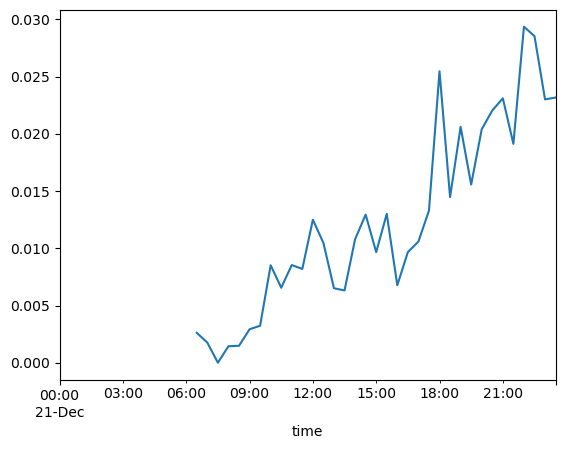

In [26]:
sos_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221221'].value.plot()

In [68]:
import pandas as pd
import altair as alt
f=180
# Create a DataFrame with arrow directions and positions
data_downvalley = pd.DataFrame({
    'x': [0, 0, 0, 0, 0, 0],  # x-coordinates
    'y': [0, 0, 0, 0, 0, 0],  # y-coordinates
    'angle': [360-f, 350-f, 340-f, 330-f, 320-f, 310-f,],  # angles in degrees
    'height': [1,3,5,10,15,20]
}).sort_values('height', ascending=False)

# Plot arrows using Altair
arrows_downvalley = alt.Chart(data_downvalley).mark_point(shape='arrow', filled=True, opacity=1, size=20000).encode(
    x='x:Q',
    y='y:Q',
    angle=alt.Angle('angle:Q', scale=None, ),  # Angle in degrees
    color=alt.Color('height', sort=[20,15,10,5,3,1]).scale(scheme='category20c'),
    size=alt.Size('height').scale(
        range = [1000,20000]
    ),
).properties(
    width=300,
    height=300
)

data_upvalley = pd.DataFrame({
    'x': [0, 0, 0, 0, 0, 0],  # x-coordinates
    'y': [0, 0, 0, 0, 0, 0],  # y-coordinates
    # 'angle': [50-f, 60-f, 70-f, 80-f, 90-f, 100-f,],  # angles in degrees
    'angle': [90-f, 100-f, 110-f, 120-f, 130-f, 140-f,],  # angles in degrees
    'height': [1,3,5,10,15,20]
}).sort_values('height', ascending=False)

arrows_upvalley = alt.Chart(data_upvalley).mark_point(shape='arrow', filled=True, opacity=1, size=20000).encode(
    x='x:Q',
    y='y:Q',
    angle=alt.Angle('angle:Q', scale=None, ),  # Angle in degrees
    color=alt.Color('height', sort=[20,15,10,5,3,1]).scale(scheme='category20c'),
    size=alt.Size('height').scale(
        range = [1000,20000]
    ),
).properties(
    width=300,
    height=300
)

arrows_downvalley | arrows_upvalley

alt.HConcatChart(...)

In [79]:
alt.Chart(
    sos_df.query(
        "measurement == 'surface temperature'"
    ).set_index('time').loc['20230303'].reset_index()
).mark_line(point=True).encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('Wind speed (m/s)'),
    # alt.Color('height:O'),
    alt.Shape('tower:N'),
    detail='tower:N'
).properties(width=600) + alt.Chart(
    sos_df.query(
        "measurement == 'temperature'"
    ).set_index('time').loc['20230303'].reset_index().query("height == 3")
).mark_line(point={'color':'red'},color='red').encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('Wind speed (m/s)'),
    alt.Shape('tower:N'),
    detail='tower:N'
).properties(width=600)

alt.LayerChart(...)

2025-09-09 13:50:33,806 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 3 memory: 137 MB fds: 46>>
Traceback (most recent call last):
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/ray/thirdparty_files/psutil/__init__.py", line 2139, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


# Examine KPS surface temperatures during patchy snow season

SOS data is missing surface temps in May because its missing radiation data. Fill in gaps with SPLASH-KPS-Annex LW rad measurements.

In [221]:
from sublimpy import variables

# open up SOS 5min datasets
files = [
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230512.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230513.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230514.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230515.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230516.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230518.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230519.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230520.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230521.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230522.nc",
]
datasets = [xr.open_dataset(file) for file in files]
sos_ds = xr.concat(datasets, dim='time')

# gather the variables we need for surface temp calculations and resample to 30min
sos_ds = sos_ds[[
    'Rpile_in_9m_d', 'Tcase_in_9m_d', 'Rpile_out_9m_d', 'Tcase_out_9m_d', 
    'Rpile_in_uw', 'Tcase_uw', 'Rpile_out_uw', 'Tcase_uw', 
    'IDir_c', 'IDir_d', 'IDir_uw', 'IDir_ue', 'Vtherm_c', 
    'Vtherm_d', 'Vtherm_uw', 'Vtherm_ue', 'Vpile_c', 'Vpile_d', 'Vpile_uw', 'Vpile_ue', 
]].resample(time='30min').mean()

# gather the SPLASH KPS-Annex measurements of Rlw_in
kpsann_down_long_hemisp = kpsann_df.set_index('time')[['down_long_hemisp']].to_xarray().sel(
    time = slice(sos_ds.time.values.min(), sos_ds.time.values.max())
).resample(time='30min').mean()

# add the KPS-Annex Rlw_in to the SOS dataset
sos_ds['Rlw_in_9m_d'] = kpsann_down_long_hemisp['down_long_hemisp']
sos_ds = variables.add_surface_temps(sos_ds)[['Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue']]
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')

# combine the datasets
from sublimpy import tidy
sos_df_gapfilled = pd.concat([
    # sos_df[ ~ sos_df.variable.isin(
    #     ['Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue']
    # )],
    sos_df,
    tidy.get_tidy_dataset(sos_ds, variable_names=['Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue'])
])

Let's see how much the values vary when we have both estimates

In [223]:
sos_df_gapfilled.query(
        "measurement == 'surface temperature'"
    ).set_index('time').sort_index().loc['20230522 1500'].reset_index().dropna().sort_values('variable')

,time,variable,value,height,tower,measurement
1,2023-05-22 15:00:00,Tsurf_c,29.225885,0.0,c,surface temperature
3,2023-05-22 15:00:00,Tsurf_c,29.280640,0.0,c,surface temperature
0,2023-05-22 15:00:00,Tsurf_d,27.478506,0.0,d,surface temperature
2,2023-05-22 15:00:00,Tsurf_d,27.534210,0.0,d,surface temperature
5,2023-05-22 15:00:00,Tsurf_ue,30.803384,0.0,ue,surface temperature
7,2023-05-22 15:00:00,Tsurf_ue,30.857300,0.0,ue,surface temperature
4,2023-05-22 15:00:00,Tsurf_uw,14.101170,0.0,uw,surface temperature
6,2023-05-22 15:00:00,Tsurf_uw,14.165009,0.0,uw,surface temperature


They are very similar. Let's take the mean so we don't have overlaps

In [225]:
sos_df = sos_df_gapfilled.groupby(['time', 'variable', 'height', 'tower', 'measurement']).mean().reset_index()

In [254]:
alt.Chart(
    sos_df.query(
        "measurement == 'surface temperature'"
    ).set_index('time').sort_index().loc['20230510': '20230522'].reset_index().dropna().query("value > -10")
).mark_line().encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('Surface temperature'),
    alt.Color('tower:N'),
).properties(width=600, height=150)

alt.Chart(...)

In [66]:
alt.Chart(
    sos_df.query(
        "measurement == 'wind direction'"
    ).set_index('time').loc['20230204'].reset_index().query("height > 2")
).mark_line(point=True).encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('Wind speed (m/s)'),
    alt.Color('height:O'),
    alt.Shape('tower:N'),
).properties(width=600)

alt.Chart(...)

In [28]:
(alt.Chart(
    sos_df.query(
        "measurement == 'wind speed'"
    ).query("tower == 'c'").set_index('time').loc['20230303'].reset_index()
).mark_line().encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('Wind speed (m/s)'),
    alt.Color('height:O'),
    tooltip='height'
).properties(width=600, height=100) &\
alt.Chart(
    sos_df.query(
        "measurement == 'turbulent kinetic energy'"
    ).query("tower == 'c'").set_index('time').loc['20230303'].reset_index()
).mark_line().encode( 
    alt.X('time:T') ,
    alt.Y('value:Q').title('TKE (m^2 s^-2)'),
    alt.Color('height:O'),
    tooltip='height'
).properties(width=600, height=100)).resolve_scale(x='shared', color='shared')

alt.VConcatChart(...)

In [10]:
alt.Chart(
    sos_df.query(
        "measurement == 'wind direction'"
    ).query("tower == 'c'").set_index('time').loc['20230303'].reset_index()
).mark_circle().encode( 
    alt.X('time:T') ,
    alt.Y('value:Q'),
    alt.Color('height:O'),
    tooltip='height'
).properties(width=800)

alt.Chart(...)

In [39]:
# USING POTENTIAL TEMPERATURE
################################################
# kpsann_tpot_series = pd.Series(
#     potential_temperature(
#         kpsann_df['atmos_pressure'].values * units("millibar"), 
#         kpsann_df['temp'].values * units('celsius')
#     ).magnitude,
#     index = kpsann_df['atmos_pressure'].index
# ).rename('Tpot_kpsann')
# avp_tpot_series = pd.Series(
#     potential_temperature(
#         avp_df['atmos_pressure'].values * units("millibar"), 
#         avp_df['temp'].values * units('celsius')
#     ).magnitude,
#     index = avp_df['atmos_pressure'].index
# ).rename('Tpot_avp')
# horiz_adv_df = pd.DataFrame(sos_df.query("variable == 'Tpot_3m_c'").set_index('time')['value'].rename('Tpot_kps')).join(
#     (kpsann_tpot_series - 273.5)
# ).join(
#     (avp_tpot_series - 273.5)
# )
# horiz_adv_df.head(3)

# USING REGULAR TEMPERATURE
# ################################################
horiz_adv_df = pd.DataFrame(sos_df.query("variable == 'T_3m_c'").set_index('time')['value'].rename('T_kps')).join(
    (kpsann_df['temp']).rename('T_kpsann')
).join(
    (avp_df['temp']).rename('T_avp')
)
horiz_adv_df.head(3)

,T_kps,T_kpsann,T_avp
time,,,
2022-11-07 00:30:00,-1.931202,-1.229870,-3.243544
2022-11-07 01:00:00,-1.958308,-1.590895,-4.308431
2022-11-07 01:30:00,-1.988143,-2.192464,-4.844323


In [38]:
import altair as alt
import pandas as pd
import numpy as np
from scipy.stats import linregress
# Compute regression statistics
slope, intercept, r_value, p_value, std_err = linregress(
    horiz_adv_df["T_kps"], horiz_adv_df["T_kpsann"]
)

# Create a scatter plot
scatter = alt.Chart(horiz_adv_df).mark_circle(size=10, opacity=0.5).encode(
    x=alt.X("T_kps"),
    y=alt.Y("T_kpsann"),
    tooltip=["T_kps", "T_kpsann"]
)

# Add a 1:1 line
one_to_one = alt.Chart(pd.DataFrame({
    "x": [horiz_adv_df["T_kps"].min(), horiz_adv_df["T_kps"].max()],
    "y": [horiz_adv_df["T_kps"].min(), horiz_adv_df["T_kps"].max()]
})).mark_line(color="red", strokeDash=[5, 5]).encode(
    x="x:Q",
    y="y:Q"
)

# Add a line of best fit
best_fit = scatter.transform_regression(
    "T_kps", "T_kpsann", method="linear"
).mark_line(color="blue")

# Combine all layers
final_plot = (scatter + one_to_one + best_fit).properties(
    width=400,
    height=400
)

final_plot.show()

KeyError: 'T_kps'

In [40]:
import altair as alt
import pandas as pd
import numpy as np
from scipy.stats import linregress
# Compute regression statistics
slope, intercept, r_value, p_value, std_err = linregress(
    horiz_adv_df["T_avp"], horiz_adv_df["T_kpsann"]
)

# Create a scatter plot
scatter = alt.Chart(horiz_adv_df).mark_circle(size=10, opacity=0.5).encode(
    x=alt.X("T_avp"),
    y=alt.Y("T_kpsann"),
    tooltip=["T_avp", "T_kpsann"]
)

# Add a 1:1 line4
one_to_one = alt.Chart(pd.DataFrame({
    "x": [horiz_adv_df["T_avp"].min(), horiz_adv_df["T_avp"].max()],
    "y": [horiz_adv_df["T_avp"].min(), horiz_adv_df["T_avp"].max()]
})).mark_line(color="red", strokeDash=[5, 5]).encode(
    x="x:Q",
    y="y:Q"
)

# Add a line of best fit
best_fit = scatter.transform_regression(
    "T_avp", "T_kpsann", method="linear"
).mark_line(color="blue")

# Combine all layers
final_plot = (scatter + one_to_one + best_fit).properties(
    width=400,
    height=400
)

final_plot.show()

alt.LayerChart(...)

In [41]:
# Downvalley is positive X direction
DELTA_X = 400 #m
horiz_adv_df['delta_T'] = ( horiz_adv_df['T_kpsann'] - horiz_adv_df['T_kps'] )
horiz_adv_df['delta_T_delta_x'] = horiz_adv_df['delta_T'] / DELTA_X
# Get wind speed values
horiz_adv_df = horiz_adv_df.join(
    sos_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('U')
)

# Only include downvalley and upvalley wind directions and ensure U is positive/negative
# for downvalley/upvalley
horiz_adv_df_downvalley = horiz_adv_df[horiz_adv_df.index.isin(downvalley_wind_times)]
horiz_adv_df_upvalley = horiz_adv_df[horiz_adv_df.index.isin(upvalley_wind_times)]
horiz_adv_df_upvalley['U'] = - horiz_adv_df_upvalley['U']
horiz_adv_df = pd.concat([horiz_adv_df_downvalley, horiz_adv_df_upvalley]).sort_index()
horiz_adv_df['horizontal_advection'] = horiz_adv_df['delta_T_delta_x'] * horiz_adv_df['U']

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_66976/3896882100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horiz_adv_df_upvalley['U'] = - horiz_adv_df_upvalley['U']


In [42]:
adv_df = adv_df.join(
    horiz_adv_df[['horizontal_advection', 'delta_T_delta_x', 'delta_T']]
)

# Plot

In [ ]:
nobs_dovalley_times = nobs_times.intersection(set(pd.to_datetime(downvalley_wind_times)))
nobs_upvalley_times = nobs_times.intersection(set(pd.to_datetime(upvalley_wind_times)))
len(nobs_dovalley_times), len(nobs_upvalley_times)

## Transport terms - flux densities, w/ vertical advection

In [ ]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10',  'horizontal_advection',
        # 'flux_div_3to20',
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    )
    advection_chart = alt.Chart(
        src[[
            # 'vertical_advection_2m_c', 
            'vertical_advection_3m_c', 
            'vertical_advection_5m_c', 
            'vertical_advection_10m_c', 
            # 'vertical_advection_15m_c', 
            # 'vertical_advection_20m_c',
            'time'
        ]].rename(columns = {
            # 'vertical_advection_2m_c': '2',
            'vertical_advection_3m_c': '3',
            'vertical_advection_5m_c': '5',
            'vertical_advection_10m_c': '10',
            # 'vertical_advection_15m_c': '15',
            # 'vertical_advection_20m_c': '20',
        })
    ).transform_fold([
        # '2', 
        '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:N').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=300, height=175)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


In [ ]:
vert_t_diff_df = sos_df.query("variable == 'T_3m_c'").set_index('time')[['value']].join(
    sos_df.query("variable == 'T_20m_c'").set_index('time')['value'].rename('T_20m_c')
).rename(columns={'value': 'T_3m_c'})
vert_t_diff_df['delta_T_vert'] = vert_t_diff_df['T_20m_c'] - vert_t_diff_df['T_3m_c']

In [ ]:
(adv_df[['delta_T']].abs() > 0.45).value_counts()

In [ ]:
(vert_t_diff_df[['delta_T_vert']].abs() > 0.2).value_counts()

In [ ]:
def vert_rule(x):
    return alt.Chart().transform_calculate(x=f'{x}').mark_rule().encode(x='x:Q')
horiz_t_uncertainty = (
    alt.Chart(adv_df[['delta_T']]).mark_bar(
        color='#d62728', opacity=0.5
    ).encode(
        alt.X('delta_T:Q').bin(step=0.1).axis(values=[-4,-3,-2,-1,0,1,2,3,4]).scale(domain=[-4,4], clamp=True).title('∆T, KPS - KPSAnnex (˚C)'),
        alt.Y('count():Q')
    ).properties(width=400, height=200) + vert_rule(0.3) + vert_rule(-0.3) + vert_rule(0.45) + vert_rule(-0.45)
)

vert_t_uncertainty = (
    alt.Chart(vert_t_diff_df[['delta_T_vert']]).mark_bar(
        color='#d62728', opacity=0.5
    ).encode(
        alt.X('delta_T_vert:Q').bin(step=0.1).axis(values=[-4,-3,-2,-1,0,1,2,3,4]).scale(domain=[-4,4], clamp=True).title('∆T, KPS₂₀ₘ - KPS₃ₘ (˚C)'),
        alt.Y('count():Q')
    ).properties(width=400, height=200) + vert_rule(0.2) + vert_rule(-0.2)
)

(horiz_t_uncertainty & vert_t_uncertainty).resolve_scale(x='shared')

In [ ]:
alt.Chart(
    sos_df[sos_df.variable.isin([
        'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c'
    ])].set_index('time').loc['20230517'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q'),
    alt.Y('height'),
    alt.Facet('hours(time)', columns=6, spacing=0),
    order='height'
).properties(width=100, height=100)

In [ ]:
adv_df['residual'] = - adv_df[['vertical_turb_flux_divergence_3to5', 'horizontal_advection', 'vertical_advection_3m_c', 'storage_change_3m']].sum(axis=1)
alt.Chart(
    adv_df.loc['20230418'].reset_index()
).mark_line().transform_fold(
    [
        'vertical_turb_flux_divergence_3to5', 'horizontal_advection', 'vertical_advection_3m_c',
        'storage_change_3m', 
         'residual'
    ]
).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04, 0.04], clamp=True),
    alt.Color('key:N')
).properties(width=400)

In [ ]:

alt.Chart(
    adv_df.loc['20230514': '20230521'].reset_index().rename(columns={
        'vertical_turb_flux_divergence_3to5' :  'VTFD_3to5',
        'vertical_turb_flux_divergence_3to10' : 'VTFD_3to10',
        'vertical_turb_flux_divergence_3to20' : 'VTFD_3to20',
    })
).mark_line().transform_fold(
    ['VTFD_3to5', 'VTFD_3to10', 'VTFD_3to20']
).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04, 0.04], clamp=True),
    alt.Color('key:N').sort(['VTFD_3to5', 'VTFD_3to10', 'VTFD_3to20'])
).properties(width=800)

In [ ]:
adv_df['residual'] = - adv_df[['vertical_turb_flux_divergence_3to10', 'horizontal_advection', 'vertical_advection_3m_c', 'storage_change_3m']].sum(axis=1)

alt.Chart(
    adv_df.loc['20230514': '20230521'].reset_index()
).mark_line().transform_fold(
    [
        'vertical_turb_flux_divergence_3to10', 'horizontal_advection', 'vertical_advection_3m_c',
        'storage_change_3m', 
         'residual'
    ]
).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(domain=[-0.04, 0.04], clamp=True),
    alt.Color('key:N')
).properties(width=800)

In [ ]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[['horizontal_advection', 'time']]
    ).transform_fold(['horizontal_advection']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(horizontal_advection):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [ ]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


## Fluxes - w/ corrections

In [ ]:
adv_df['w_tc__2m_c_corrected'] = adv_df['w_tc__2m_c'] + 2*adv_df['vertical_advection_2m_c']
adv_df['w_tc__3m_c_corrected'] = (
    adv_df['w_tc__3m_c'] + 2*adv_df['vertical_advection_2m_c'] + 1*adv_df['vertical_advection_3m_c']
)
adv_df['w_tc__5m_c_corrected'] = (
    adv_df['w_tc__5m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 1*adv_df['vertical_advection_5m_c']
)
adv_df['w_tc__10m_c_corrected'] = (
    adv_df['w_tc__10m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 2.5*adv_df['vertical_advection_10m_c']
)
adv_df['w_tc__15m_c_corrected'] = (
    adv_df['w_tc__15m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 5*adv_df['vertical_advection_10m_c'] + 2.5*adv_df['vertical_advection_15m_c']
)
adv_df['w_tc__20m_c_corrected'] = (
    adv_df['w_tc__20m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 5*adv_df['vertical_advection_10m_c'] + 5*adv_df['vertical_advection_15m_c'] + 2.5*adv_df['vertical_advection_20m_c']
)

In [ ]:
src = adv_df[[
    'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',    
    'w_tc__2m_c_corrected',
    'w_tc__3m_c_corrected',
    'w_tc__5m_c_corrected',
    'w_tc__10m_c_corrected',
    'w_tc__15m_c_corrected',
    'w_tc__20m_c_corrected',    
]].drop_duplicates().sort_index()
src = src.loc['20221130': '20230508']
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('__')[1].split('m_c')[0]))
src['measurement'] = src['variable'].apply(lambda s: s.split('_')[-1])
src['measurement'] = src['measurement'].replace({'c': 'raw'})
src = src.reset_index()

In [ ]:
import altair as alt

In [ ]:
def plot(src):
    return alt.Chart(
        src.reset_index()
    ).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Facet('height:O', columns=1, spacing=0).header(
            labelPadding=-15, labelFontStyle='bold', labelFontSize=12, labelAnchor='end'
        ),
        # alt.Color('height:O').scale(scheme='rainbow'),
        alt.StrokeDash('measurement:N')
    ).properties(width=200, height=75)

(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
)

In [ ]:
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
src['value_watts'] = w_tc_to_watts(src['value'].values)
src

In [ ]:
def plot(src):
    return alt.Chart(
        src.reset_index()
    ).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value_watts):Q').title('Hₛ (W/m²)'),
        alt.Facet('height:O', columns=2, spacing=0).header(labelPadding=-15, labelFontStyle='bold', labelFontSize=12, labelAnchor='end', titleFontSize=0),
        # alt.Color('height:O').scale(scheme='rainbow'),
        alt.StrokeDash('measurement:N')
    ).properties(width=200, height=75)

(
    plot(src[src.time.isin(nobs_upvalley_times)]).properties(title = 'upvalley winds')
    | 
    plot(src[src.time.isin(nobs_dovalley_times)]).properties(title = 'downvalley winds')
).resolve_scale(color='independent', x='shared', y='shared').properties(
    title = ['Seasonal composites of sensible heat flux (raw) with',
    'vertical advection correction applied (corrected) at multiple heights']
).display(renderer='svg')

## Storage change terms

In [ ]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[[
            'storage_change_2m', 
            'storage_change_3m', 
            'storage_change_5m', 
            'storage_change_10m', 
            'storage_change_15m', 
            'storage_change_20m',
            'time'
        ]].rename(columns = {
            'storage_change_2m': '2',
            'storage_change_3m': '3',
            'storage_change_5m': '5',
            'storage_change_10m': '10',
            'storage_change_15m': '15',
            'storage_change_20m': '20',
        })
    ).transform_fold([
        '2', '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:O').scale(scheme='rainbow').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

$$H_s = $$

In [ ]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


## Horizontal advection terms

In [ ]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[['horizontal_advection', 'time']]
    ).transform_fold(['horizontal_advection']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(horizontal_advection):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [ ]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


In [ ]:
def plot(src):
    return alt.Chart(
        src[['delta_T_delta_x', 'time']]
    ).transform_fold(['delta_T_delta_x']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(delta_T_delta_x):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

In [ ]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


## W

In [ ]:
def plot(src):
    return alt.Chart(
        src[[
            'w_2m_c', 
            'w_3m_c', 
            'w_5m_c', 
            'w_10m_c', 
            'w_15m_c', 
            'w_20m_c',
            'time'
        ]].rename(columns = {
            'w_2m_c': '2',
            'w_3m_c': '3',
            'w_5m_c': '5',
            'w_10m_c': '10',
            'w_15m_c': '15',
            'w_20m_c': '20',
        })
    ).transform_fold([
        '2', '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:O').scale(scheme='rainbow').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=200, height=125)

In [ ]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


In [ ]:
src = tidy_df.query("tower == 'c'").query("measurement == 'wind direction'")
src = src[(src.time > '20221101') & (src.time < '20221115')]
src.value = src.value.apply(lambda x: x if x > 50 else x+360)
src = src[src.height.isin([2,5,10,20])]
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=800).interactive()

In [ ]:
[
    'delta_T_delta_x',

    'horizontal_advection',

    'storage_change_10m',
    'storage_change_15m',
    'storage_change_20m',
    'storage_change_2m',
    'storage_change_3m',
    'storage_change_5m',

    'vertical_advection_2m_c',
    'vertical_advection_3m_c',
    'vertical_advection_5m_c',
    'vertical_advection_10m_c',
    'vertical_advection_15m_c',
    'vertical_advection_20m_c',

    'vertical_turb_flux_divergence_3to5',
    'vertical_turb_flux_divergence_3to10',
    'vertical_turb_flux_divergence_3to20',

    'w_2m_c',
    'w_3m_c',
    'w_5m_c',
    'w_10m_c',
    'w_15m_c',
    'w_20m_c',

    'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',
    
    'w_tc__2m_c_corrected',
    'w_tc__3m_c_corrected',
    'w_tc__5m_c_corrected',
    'w_tc__10m_c_corrected',
    'w_tc__15m_c_corrected',
    'w_tc__20m_c_corrected',   
]